In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/data.json'
chunk_size = 100000

# Load and combine chunks
chunks = pd.read_json(file_path, lines=True, chunksize=chunk_size)
data = pd.concat(chunks)

# Display all columns
print(data.columns)

Index(['status', 'gender', 'length', 'firstName', 'level', 'lastName',
       'registration', 'userId', 'ts', 'auth', 'page', 'sessionId', 'location',
       'itemInSession', 'userAgent', 'song', 'artist', 'method'],
      dtype='object')


[LightGBM] [Info] Number of positive: 3502, number of negative: 12092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 15594, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      5183
           1       0.57      0.78      0.66      1501

    accuracy                           0.82      6684
   macro avg       0.75      0.81      0.77      6684
weighted avg       0.85      0.82      0.83      6684

ROC AUC: 0.864

Random Forest Performance:
              precision    recall  f1-sco

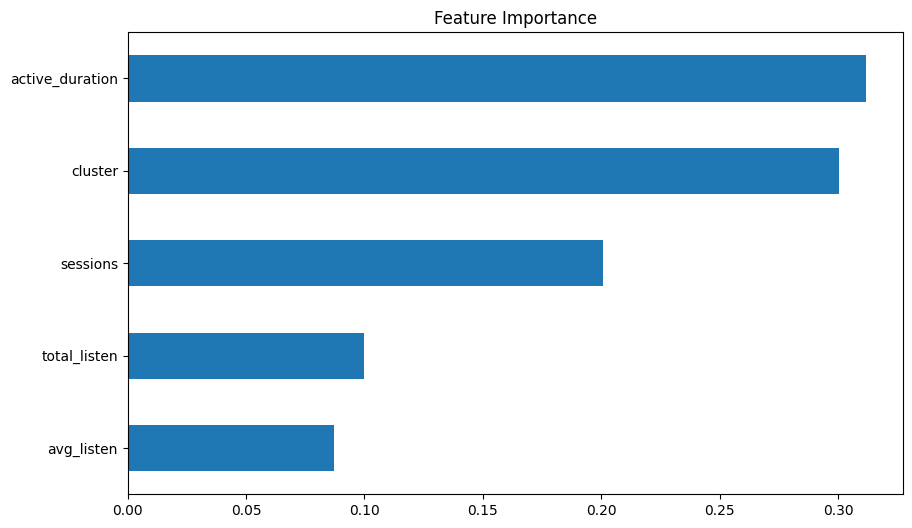

In [ ]:
# ========================
# Data Preprocessing
# ========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load data in chunks for memory efficiency
CHUNKSIZE = 100000
dtypes = {
    'userId': 'category',
    'gender': 'category',
    'page': 'category',
    'level': 'category',
    'userAgent': 'category',
    'location': 'category'
}

def load_data(file_path):
    chunks = pd.read_json(file_path, lines=True, chunksize=CHUNKSIZE, dtype=dtypes)
    return pd.concat(chunks)

# Initialize preprocessing pipeline
def preprocess_data(df):
    # Create churn label
    df['churn'] = (df['page'] == 'Cancellation Confirmation').astype(int)

    # Handle missing values
    num_cols = ['length', 'itemInSession']
    cat_cols = ['gender', 'level', 'userAgent', 'location']

    # Convert 'ts' to datetime objects
    df['ts'] = pd.to_datetime(df['ts'], unit='ms') # Assuming 'ts' is in milliseconds

    # Group by user and create behavioral features
    user_features = df.groupby('userId').agg({
    'length': ['sum', 'mean'],
    'sessionId': 'nunique',
    'ts': lambda x: (x.max() - x.min()).total_seconds(),
    'churn': 'max'
}).reset_index()

    user_features.columns = ['userId', 'total_listen', 'avg_listen',
                            'sessions', 'active_duration', 'churn']

    return user_features

# ========================
# Clustering with GMM
# ========================
def cluster_users(user_features):
    cluster_cols = ['total_listen', 'avg_listen', 'sessions', 'active_duration']

    # Scale features
    scaler = StandardScaler()
    # Impute NaN values with the mean of each column before scaling
    user_features[cluster_cols] = user_features[cluster_cols].fillna(user_features[cluster_cols].mean())
    X_scaled = scaler.fit_transform(user_features[cluster_cols])

    # Apply Gaussian Mixture Model
    gmm = GaussianMixture(n_components=5, random_state=42)
    user_features['cluster'] = gmm.fit_predict(X_scaled)

    return user_features

# ========================
# Model Building Pipeline
# ========================
def build_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'XGBoost': XGBClassifier(scale_pos_weight=25),
        'LightGBM': lgb.LGBMClassifier(class_weight='balanced')
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }

        trained_models[name] = model

    return results, trained_models

# ========================
# Feature Importance Visualization
# ========================
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names)
    elif hasattr(model, 'coef_'):
        importance = pd.Series(np.abs(model.coef_[0]), index=feature_names)
    else:
        # Handle case where neither attribute is found
        print("Model does not have feature importance attributes.")
        return # Exit the function to prevent errors

    importance.sort_values().plot(kind='barh', figsize=(10,6))
    plt.title('Feature Importance')
    plt.show()

# ========================
# Main Execution
# ========================
# ========================
# Main Execution
# ========================
if __name__ == "__main__": # Changed _name_ to __name__
    # Load and preprocess data
    df = load_data('/content/drive/MyDrive/data.json')
    user_features = preprocess_data(df)

    # Perform clustering
    user_features = cluster_users(user_features)

    # Prepare modeling data
    X = user_features.drop(['userId', 'churn'], axis=1)
    y = user_features['churn']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # Train and compare models
    results, trained_models = build_models(X_train, X_test, y_train, y_test)

    # Display results
    for model_name, metrics in results.items():
        print(f"\n{model_name} Performance:")
        print(metrics['classification_report'])
        print(f"ROC AUC: {metrics['roc_auc']:.3f}")

    # Example feature importance visualization
    plot_feature_importance(trained_models['XGBoost'], X.columns)

=== Dropout Analysis ===
Total events in the dataset: 26259199
Total dropout events (Cancellation Confirmation): 5003
Dropout event rate: 0.02%

Total unique users: 22278
Total users who churned: 5003
User churn rate: 22.46%

Churn count in user_features: 5003
Total users in user_features: 22278
User churn rate in processed data: 22.46%

=== Cluster Analysis ===


<Figure size 1200x600 with 0 Axes>

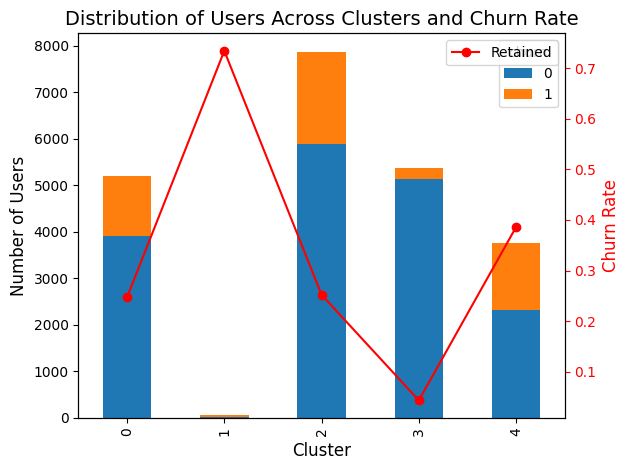


=== Model Training ===
Training set size: 15594 samples
Test set size: 6684 samples
Positive samples in training: 3502 (22.46%)
Positive samples in testing: 1501 (22.46%)
[LightGBM] [Info] Number of positive: 3502, number of negative: 12092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Number of data points in the train set: 15594, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

=== Model Performance ===

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      5183
           1       0.57      0.78      0.66      1501

    accuracy                           0.82      6684
   macro avg       0.75      0.81      0.77      6684
weig

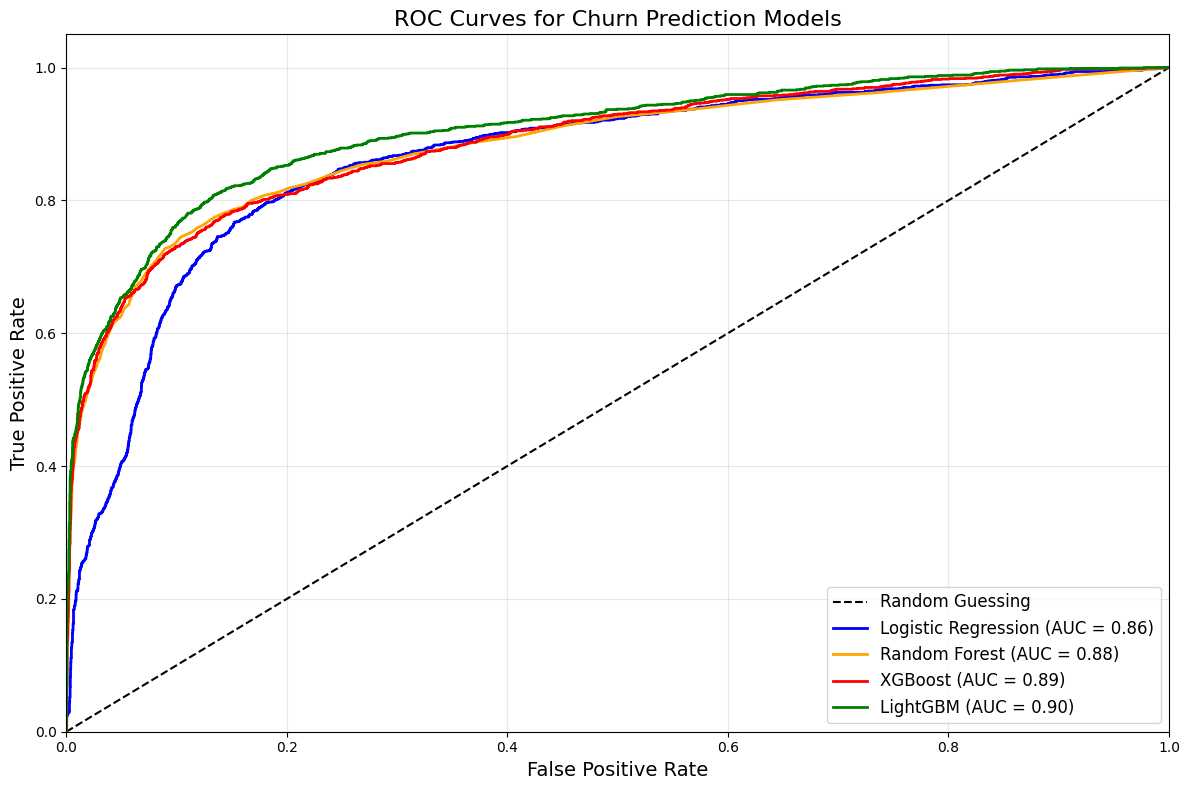


=== Confusion Matrix Visualization ===


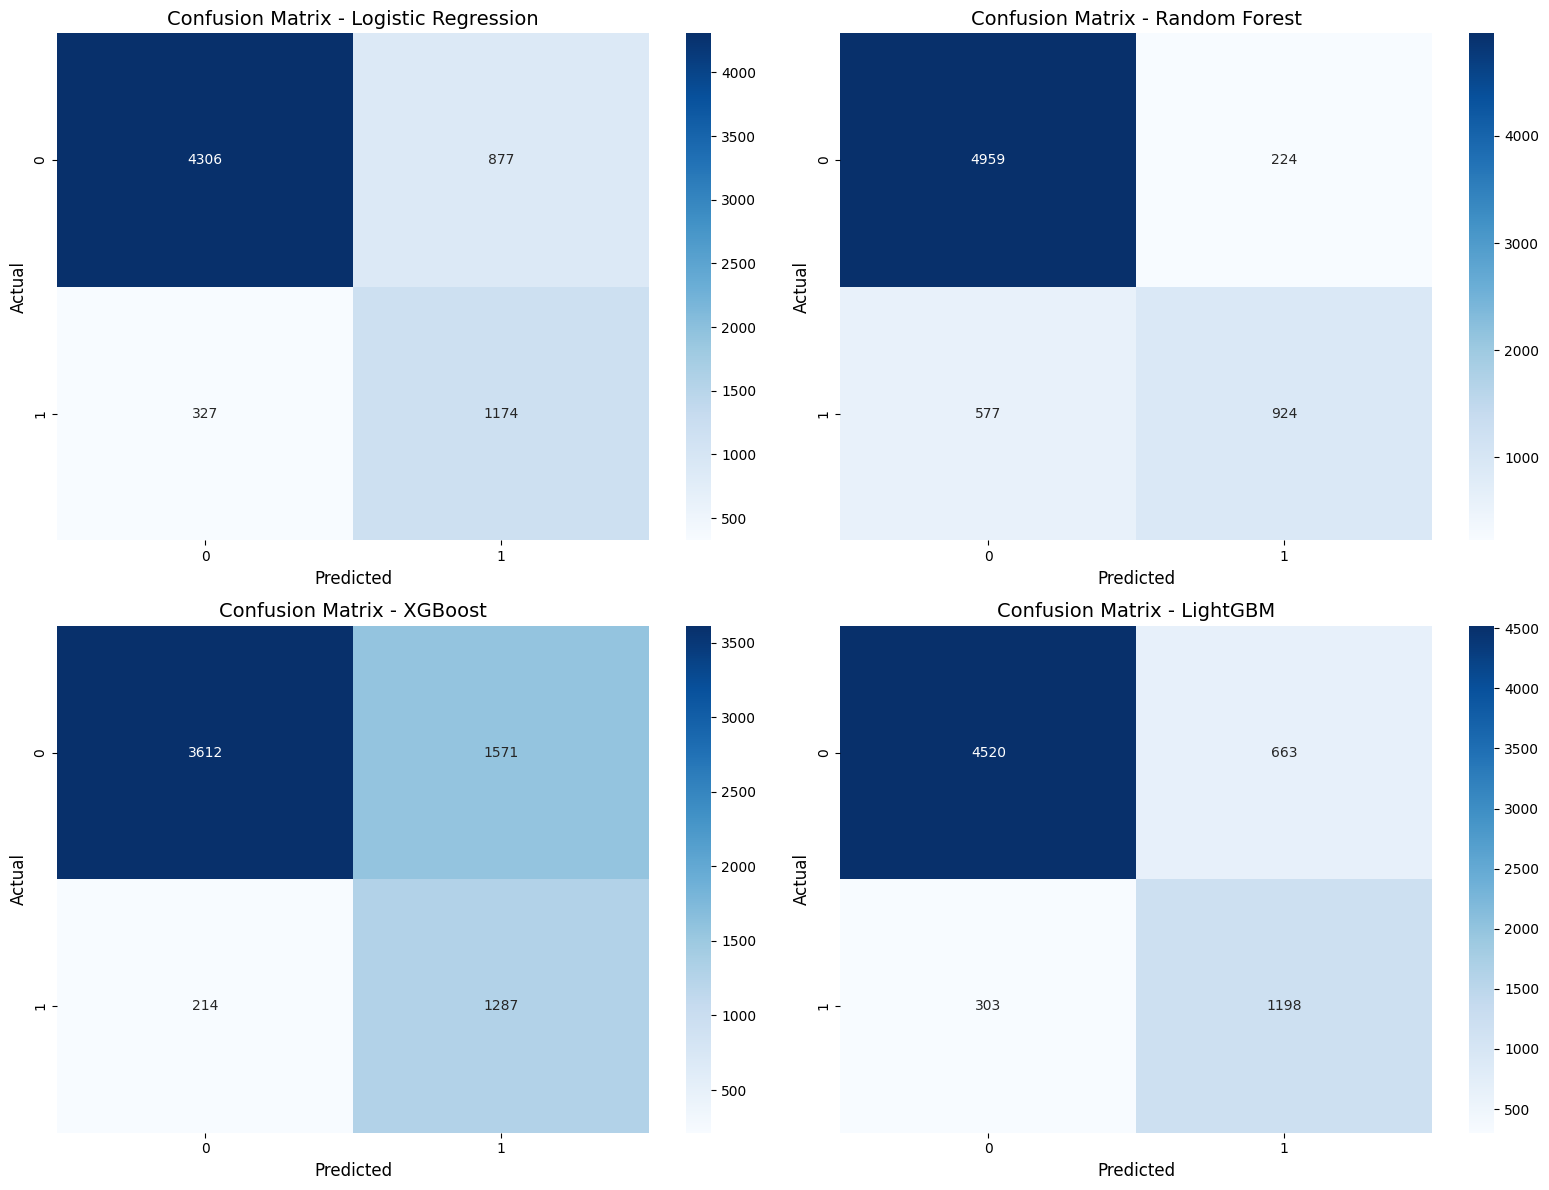


=== Feature Importance Visualization ===
XGBoost Feature Importance:


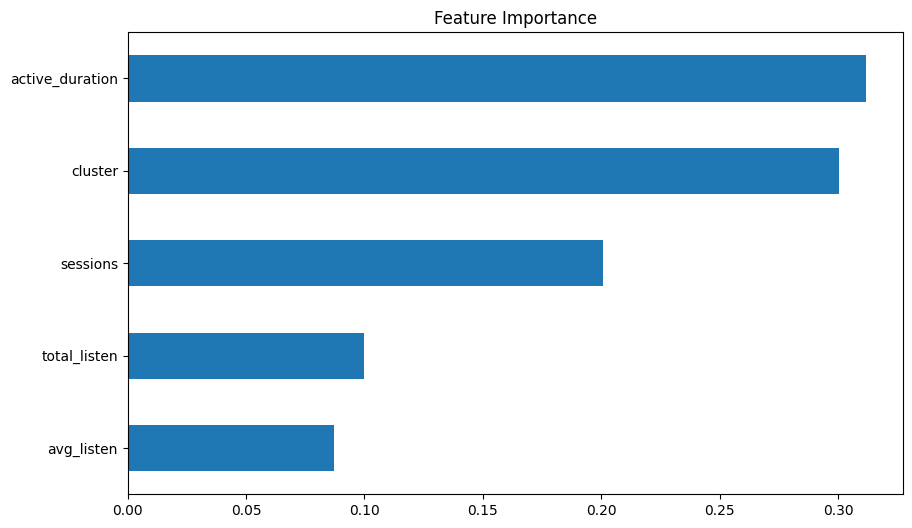

LightGBM Feature Importance:


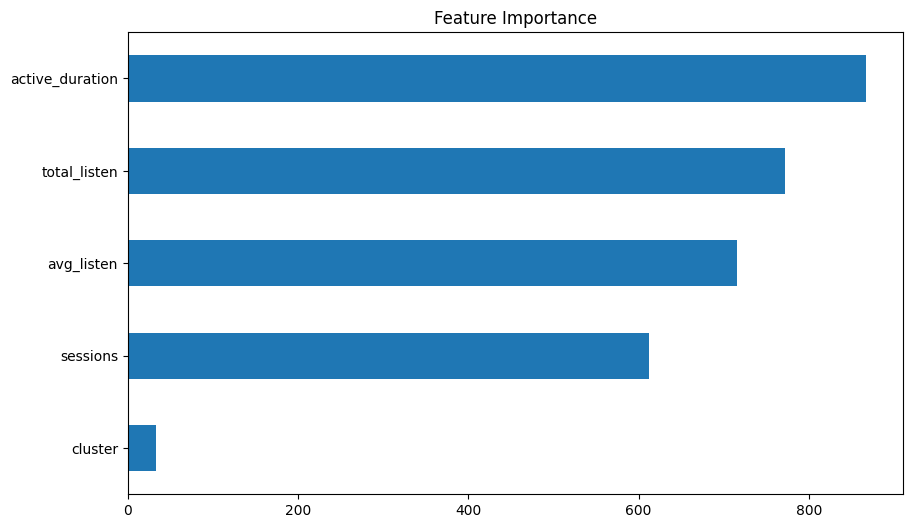

In [ ]:
# ========================
# Data Preprocessing
# ========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load data in chunks for memory efficiency
CHUNKSIZE = 100000
dtypes = {
    'userId': 'category',
    'gender': 'category',
    'page': 'category',
    'level': 'category',
    'userAgent': 'category',
    'location': 'category'
}

def load_data(file_path):
    chunks = pd.read_json(file_path, lines=True, chunksize=CHUNKSIZE, dtype=dtypes)
    return pd.concat(chunks)

# Initialize preprocessing pipeline
def preprocess_data(df):
    # Create churn label
    df['churn'] = (df['page'] == 'Cancellation Confirmation').astype(int)

    # Handle missing values
    num_cols = ['length', 'itemInSession']
    cat_cols = ['gender', 'level', 'userAgent', 'location']

    # Convert 'ts' to datetime objects
    df['ts'] = pd.to_datetime(df['ts'], unit='ms') # Assuming 'ts' is in milliseconds

    # Group by user and create behavioral features
    user_features = df.groupby('userId').agg({
    'length': ['sum', 'mean'],
    'sessionId': 'nunique',
    'ts': lambda x: (x.max() - x.min()).total_seconds(),
    'churn': 'max'
}).reset_index()

    user_features.columns = ['userId', 'total_listen', 'avg_listen',
                            'sessions', 'active_duration', 'churn']

    return user_features

# ========================
# Count Total Dropout Rows
# ========================
def count_dropouts(df):
    # Count rows where page is 'Cancellation Confirmation'
    dropout_events = df[df['page'] == 'Cancellation Confirmation'].shape[0]
    total_events = df.shape[0]
    print(f"Total events in the dataset: {total_events}")
    print(f"Total dropout events (Cancellation Confirmation): {dropout_events}")
    print(f"Dropout event rate: {dropout_events/total_events:.2%}")

    # Count unique users who churned
    unique_users = df['userId'].nunique()
    churned_users = df[df['page'] == 'Cancellation Confirmation']['userId'].nunique()
    print(f"\nTotal unique users: {unique_users}")
    print(f"Total users who churned: {churned_users}")
    print(f"User churn rate: {churned_users/unique_users:.2%}")

    return dropout_events, churned_users


# ========================
# Clustering with GMM
# ========================
def cluster_users(user_features):
    cluster_cols = ['total_listen', 'avg_listen', 'sessions', 'active_duration']

    # Scale features
    scaler = StandardScaler()
    # Impute NaN values with the mean of each column before scaling
    user_features[cluster_cols] = user_features[cluster_cols].fillna(user_features[cluster_cols].mean())
    X_scaled = scaler.fit_transform(user_features[cluster_cols])

    # Apply Gaussian Mixture Model
    gmm = GaussianMixture(n_components=5, random_state=42)
    user_features['cluster'] = gmm.fit_predict(X_scaled)

    return user_features

# ========================
# Model Building Pipeline
# ========================
def build_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'XGBoost': XGBClassifier(scale_pos_weight=25),
        'LightGBM': lgb.LGBMClassifier(class_weight='balanced')
    }

    results = {}
    trained_models = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }

        trained_models[name] = model

    return results, trained_models

# ========================
# Feature Importance Visualization
# ========================
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names)
    elif hasattr(model, 'coef_'):
        importance = pd.Series(np.abs(model.coef_[0]), index=feature_names)
    else:
        # Handle case where neither attribute is found
        print("Model does not have feature importance attributes.")
        return # Exit the function to prevent errors

    importance.sort_values().plot(kind='barh', figsize=(10,6))
    plt.title('Feature Importance')
    plt.show()

# ========================
# ROC Curve Visualization
# ========================
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 8))

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    colors = ['blue', 'orange', 'red', 'green']

    for (name, model), color in zip(models.items(), colors):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{name} (AUC = {roc_auc:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves for Churn Prediction Models', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# ========================
# Additional Visualizations
# ========================
def plot_confusion_matrices(models, X_test, y_test):
    """Plot confusion matrices for all models"""
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.flatten()

    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i])
        axs[i].set_title(f'Confusion Matrix - {name}', fontsize=14)
        axs[i].set_xlabel('Predicted', fontsize=12)
        axs[i].set_ylabel('Actual', fontsize=12)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_cluster_distribution(user_features):
    """Plot distribution of churned users across clusters"""
    plt.figure(figsize=(12, 6))

    # Count users in each cluster by churn status
    cluster_churn = user_features.groupby(['cluster', 'churn']).size().unstack().fillna(0)

    # Calculate churn rate per cluster
    if 1 not in cluster_churn.columns:
        cluster_churn[1] = 0
    if 0 not in cluster_churn.columns:
        cluster_churn[0] = 0

    cluster_churn['churn_rate'] = cluster_churn[1] / (cluster_churn[0] + cluster_churn[1])

    # Plot
    ax = cluster_churn[[0, 1]].plot(kind='bar', stacked=True)
    ax2 = ax.twinx()
    cluster_churn['churn_rate'].plot(color='red', marker='o', linestyle='-', ax=ax2)

    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Number of Users', fontsize=12)
    ax2.set_ylabel('Churn Rate', color='red', fontsize=12)
    ax2.tick_params(axis='y', colors='red')

    plt.title('Distribution of Users Across Clusters and Churn Rate', fontsize=14)
    plt.legend(['Retained', 'Churned', 'Churn Rate'])
    plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# ========================
# Main Execution
# ========================
if __name__ == "__main__":
    # Load and preprocess data
    df = load_data('/content/drive/MyDrive/data.json')

    # (Rest of your main code here)

    # Count total dropouts in original data
    print("=== Dropout Analysis ===")
    dropout_events, churned_users = count_dropouts(df)

    # Process data
    user_features = preprocess_data(df)

    # Verify user-level churn counts
    user_churn_count = user_features['churn'].sum()
    print(f"\nChurn count in user_features: {user_churn_count}")
    print(f"Total users in user_features: {user_features.shape[0]}")
    print(f"User churn rate in processed data: {user_churn_count/user_features.shape[0]:.2%}")

    # Perform clustering
    user_features = cluster_users(user_features)

    # Display cluster distribution
    print("\n=== Cluster Analysis ===")
    plot_cluster_distribution(user_features)

    # Prepare modeling data
    X = user_features.drop(['userId', 'churn'], axis=1)
    y = user_features['churn']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    print(f"\n=== Model Training ===")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Positive samples in training: {y_train.sum()} ({y_train.mean():.2%})")
    print(f"Positive samples in testing: {y_test.sum()} ({y_test.mean():.2%})")

    # Train and compare models
    results, trained_models = build_models(X_train, X_test, y_train, y_test)

    # Display results
    print("\n=== Model Performance ===")
    for model_name, metrics in results.items():
        print(f"\n{model_name} Performance:")
        print(metrics['classification_report'])
        print(f"ROC AUC: {metrics['roc_auc']:.3f}")

    # Visualize ROC curves
    print("\n=== ROC Curve Visualization ===")
    plot_roc_curves(trained_models, X_test, y_test)

    # Visualize confusion matrices
    print("\n=== Confusion Matrix Visualization ===")
    plot_confusion_matrices(trained_models, X_test, y_test)

    # Example feature importance visualization
    print("\n=== Feature Importance Visualization ===")
    print("XGBoost Feature Importance:")
    plot_feature_importance(trained_models['XGBoost'], X.columns)

    print("LightGBM Feature Importance:")
    plot_feature_importance(trained_models['LightGBM'], X.columns)


Logistic Regression Performance:
              precision    recall  f1-score   support

       False       0.86      0.59      0.70      5183
        True       0.32      0.68      0.44      1501

    accuracy                           0.61      6684
   macro avg       0.59      0.63      0.57      6684
weighted avg       0.74      0.61      0.64      6684

ROC AUC: 0.712


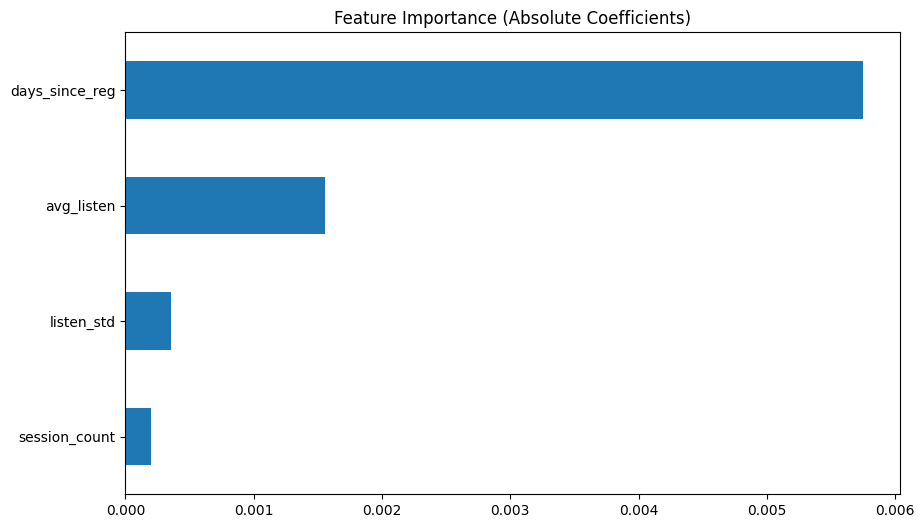


Random Forest Performance:
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      5183
        True       0.56      0.51      0.53      1501

    accuracy                           0.80      6684
   macro avg       0.71      0.70      0.70      6684
weighted avg       0.79      0.80      0.80      6684

ROC AUC: 0.730


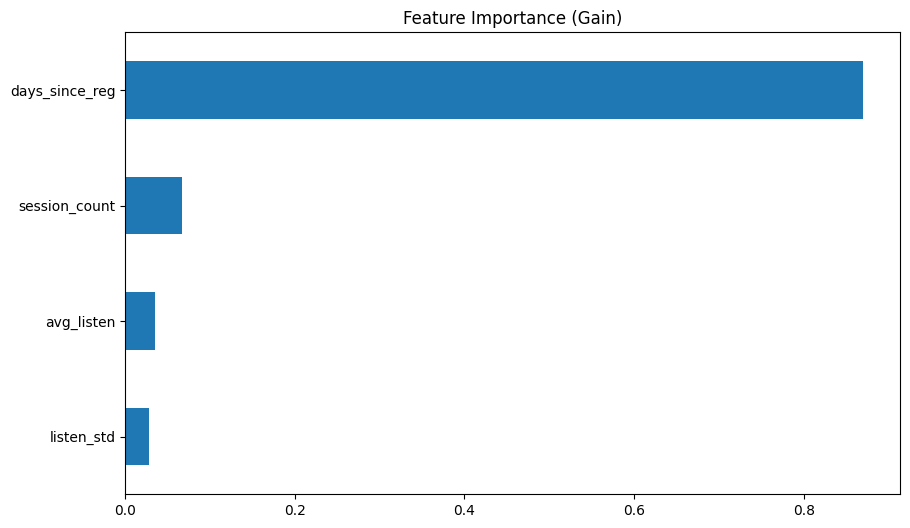


XGBoost Performance:
              precision    recall  f1-score   support

       False       0.86      0.86      0.86      5183
        True       0.51      0.51      0.51      1501

    accuracy                           0.78      6684
   macro avg       0.69      0.68      0.69      6684
weighted avg       0.78      0.78      0.78      6684

ROC AUC: 0.717


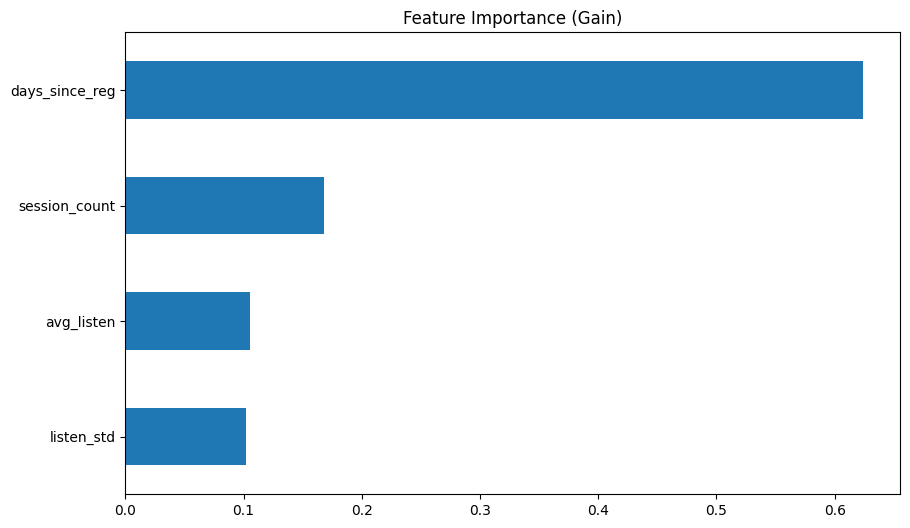

[LightGBM] [Info] Number of positive: 3502, number of negative: 12092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 15594, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM Performance:
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      5183
        True       0.54      0.51      0.53      1501

    accuracy                           0.79      6684
   macro avg       0.70      0.69      0.70      6684
weighted avg       0.79      0.79      0.79      6684

ROC AUC: 0.721


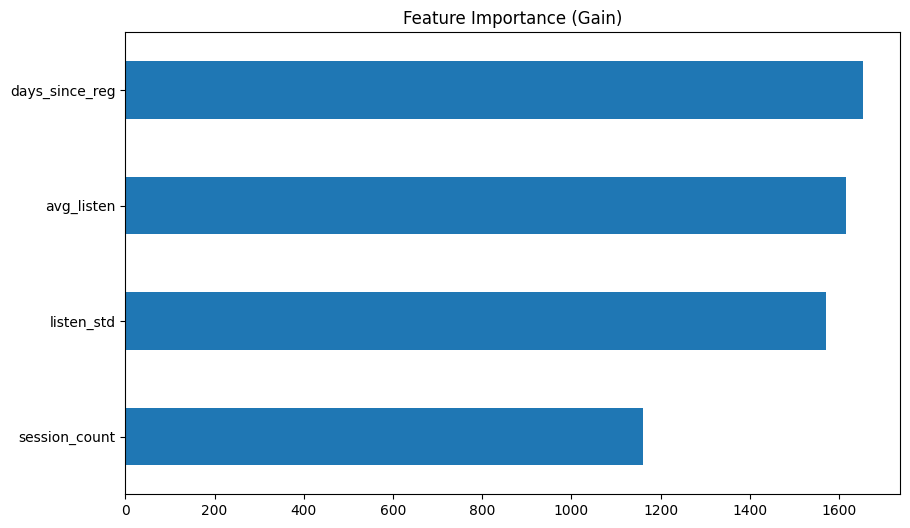

In [ ]:
# ========================
# Data Preprocessing & Feature Engineering
# ========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline  # Add this line
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import warnings

warnings.filterwarnings("ignore")

# ========================
# Load and Preprocess Data
# ========================
def load_data(file_path):
    """Load data in chunks and handle missing values."""
    try:
        chunks = pd.read_json(file_path, lines=True, chunksize=100000)
        return pd.concat(chunks)
    except FileNotFoundError:
        print("Error: File not found. Verify path or mount Google Drive:")
        print("from google.colab import drive\ndrive.mount('/content/drive')")
        return None

def create_features(df):
    """Create behavioral features with robust NaN/inf handling."""
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')

    # Calculate days since registration
    df['registration_dt'] = pd.to_datetime(df['registration'], unit='ms', errors='coerce')
    df['days_since_reg'] = (df['ts'] - df['registration_dt']).dt.days

    # Session duration calculation
    df['session_duration'] = df.groupby('sessionId')['ts'].transform(
        lambda x: (x.max() - x.min()).total_seconds()
    )

    # User-level aggregation
    user_features = df.groupby('userId').agg({
        'length': ['sum', 'mean', 'std'],
        'sessionId': 'nunique',
        'session_duration': 'mean',
        'days_since_reg': 'max',
        'page': lambda x: (x == 'Cancellation Confirmation').max()
    }).reset_index()

    # Clean column names
    user_features.columns = [
        'userId', 'total_listen', 'avg_listen', 'listen_std',
        'session_count', 'session_duration', 'days_since_reg', 'churn'
    ]

    # Handle infinite/NaN values
    numeric_cols = user_features.select_dtypes(include=np.number).columns
    user_features[numeric_cols] = user_features[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # Median imputation for all numeric columns
    imputer = SimpleImputer(strategy='median')
    user_features[numeric_cols] = imputer.fit_transform(user_features[numeric_cols])

    return user_features

# ========================
# Clustering with GMM
# ========================
def create_cluster_feature(user_features):
    """Perform GMM clustering with robust NaN handling."""
    cluster_cols = ['total_listen', 'avg_listen', 'session_count', 'days_since_reg']

    # Final NaN check before clustering
    assert user_features[cluster_cols].isna().sum().sum() == 0, \
        "NaNs present in clustering features!"

    cluster_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('gmm', GaussianMixture(
            n_components=5,
            reg_covar=1e-3,
            random_state=42
        ))
    ])

    user_features['cluster'] = cluster_pipe.fit_predict(user_features[cluster_cols])
    return user_features

# ========================
# Feature Selection
# ========================
def select_features(X, y):
    """Perform L1-regularized feature selection."""
    selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga',
                           class_weight='balanced', max_iter=1000),
        threshold="median"  # Keep at least 50% of features
    )

    X_imputed = SimpleImputer(strategy='median').fit_transform(X)
    selector.fit(X_imputed, y)

    selected = X.columns[selector.get_support()]
    if len(selected) == 0:
        print("Warning: No features selected! Using all features.")
        return X.columns
    return selected

# ========================
# Model Training & Evaluation
# ========================
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and compare multiple models."""
    class_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

    models = {
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            solver='saga',
            penalty='elasticnet',
            l1_ratio=0.5
        ),
        'Random Forest': RandomForestClassifier(
            class_weight='balanced_subsample',
            n_estimators=300,
            max_depth=5,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            scale_pos_weight=class_ratio,
            eval_metric='aucpr',
            max_depth=3,
            subsample=0.8,
            use_label_encoder=False,
            random_state=42
        ),
        'LightGBM': lgb.LGBMClassifier(
            class_weight='balanced',
            objective='binary',
            num_leaves=31,
            learning_rate=0.05,
            n_estimators=200,
            random_state=42
        )
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

        results[name] = {
            'classification': classification_report(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'model': model
        }

        print(f"\n{name} Performance:")
        print(results[name]['classification'])
        print(f"ROC AUC: {results[name]['roc_auc']:.3f}")

        plot_feature_importance(model, X_train.columns)

    return results

def plot_feature_importance(model, feature_names):
    """Universal feature importance visualization."""
    plt.figure(figsize=(10,6))

    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names)
        plt.title('Feature Importance (Gain)')
    elif hasattr(model, 'coef_'):
        importance = pd.Series(np.abs(model.coef_[0]), index=feature_names)
        plt.title('Feature Importance (Absolute Coefficients)')
    else:
        print(f"{type(model).__name__} doesn't support feature importance visualization")
        return

    importance.sort_values(ascending=True).plot.barh()
    plt.show()

# ========================
# Main Execution Flow
# ========================
if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/data.json'

    # Load data
    df = load_data(file_path)

    if df is not None:
        # Feature engineering with enhanced NaN handling
        user_features = create_features(df)

        # Clustering as a new feature
        user_features = create_cluster_feature(user_features)

        # Prepare data for modeling
        X = user_features.drop(['userId', 'churn'], axis=1)
        y = user_features['churn']

        # Feature selection step
        selected_cols = select_features(X, y)

        # Final dataset with selected features only
        X_selected = X[selected_cols]

        # Split data into training and testing sets (stratified sampling)
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.3, stratify=y, random_state=42
        )

        # Train and evaluate models (Logistic Regression + Tree Models)
        model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)


In [ ]:
# ========================
# Enhanced Preprocessing
# ========================
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def load_and_preprocess(file_path):
    """Load data with detailed missing value handling and reporting"""
    chunk_size = 100000
    chunks = pd.read_json(file_path, lines=True, chunksize=chunk_size)

    processed_chunks = []
    for chunk_num, chunk in enumerate(chunks, 1):
        # Display missing values before handling
        print(f"\nChunk {chunk_num} - Missing values before handling:")
        print(chunk.isnull().sum())

        # Define imputation strategies
        numerical_cols = ['length']
        categorical_cols = ['song', 'artist', 'gender', 'firstName',
                          'lastName', 'registration', 'location', 'userAgent']

        # Numerical imputation
        num_imputer = SimpleImputer(strategy='median')
        chunk[numerical_cols] = num_imputer.fit_transform(chunk[numerical_cols])

        # Categorical imputation
        cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
        chunk[categorical_cols] = cat_imputer.fit_transform(chunk[categorical_cols])

        # Create churn label
        chunk['churn'] = (chunk['page'] == 'Cancellation Confirmation').astype(int)

        # Convert timestamp
        chunk['ts'] = pd.to_datetime(chunk['ts'], unit='ms')

        processed_chunks.append(chunk)

    full_df = pd.concat(processed_chunks).sort_values(['userId', 'ts'])
    return full_df

# ========================
# Feature Engineering & Clustering
# ========================
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

def create_cluster_features(df):
    """Create behavioral clusters and add as new feature"""
    # Create user-level features
    user_features = df.groupby('userId').agg({
        'length': ['sum', 'mean'],
        'sessionId': 'nunique',
        'ts': lambda x: (x.max() - x.min()).total_seconds(),
        'churn': 'max'
    }).reset_index()
    user_features.columns = ['userId', 'total_listen', 'avg_listen',
                            'sessions', 'active_duration', 'churn']

    # Cluster features
    cluster_cols = ['total_listen', 'avg_listen', 'sessions', 'active_duration']

    # Clustering pipeline
    cluster_pipe = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=5, random_state=42)
    )

    user_features['cluster'] = cluster_pipe.fit_predict(user_features[cluster_cols])
    return user_features

# ========================
# Feature Selection
# ========================
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

def select_features(X, y):
    """Select features using L1-regularized logistic regression"""
    # Impute any remaining missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)

    # Feature selection
    selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
    )
    selector.fit(X_imputed, y)

    selected_features = X.columns[selector.get_support()]
    print(f"\nSelected features: {list(selected_features)}")
    return selected_features

# ========================
# Model Training
# ========================
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

def train_models(X, y):
    """Train and compare multiple models"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced'),
        'XGBoost': XGBClassifier(scale_pos_weight=np.sum(y==0)/np.sum(y==1)),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'LightGBM': LGBMClassifier(class_weight='balanced')
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]

        results[name] = {
            'classification_report': classification_report(y_test, preds, output_dict=True),
            'roc_auc': roc_auc_score(y_test, proba)
        }

        print(f"\n{name} Performance:")
        print(pd.DataFrame(results[name]['classification_report']).transpose())
        print(f"ROC AUC: {results[name]['roc_auc']:.3f}")

    return results

# ========================
# Main Execution Flow
# ========================
if __name__ == "__main__":
    # 1. Load and preprocess data
    file_path = "/content/drive/MyDrive/data.json"
    df = load_and_preprocess(file_path)

    # 2. Create cluster-enhanced features
    user_features = create_cluster_features(df)

    # 3. Prepare modeling data
    X = user_features.drop(['userId', 'churn'], axis=1)
    y = user_features['churn']

    # 4. Feature selection
    selected_cols = select_features(X, y)
    X_selected = X[selected_cols]

    # 5. Train and compare models
    model_results = train_models(X_selected, y)


Streaming output truncated to the last 5000 lines.
status               0
gender            3192
firstName         3192
level                0
lastName          3192
registration      3192
userId               0
ts                   0
auth                 0
page                 0
sessionId            0
location          3192
itemInSession        0
userAgent         3192
method               0
length           21009
song             21009
artist           21009
dtype: int64

Chunk 29 - Missing values before handling:
status               0
gender            2985
length           20226
firstName         2985
level                0
lastName          2985
registration      2985
userId               0
ts                   0
auth                 0
page                 0
sessionId            0
location          2985
itemInSession        0
userAgent         2985
song             20226
artist           20226
method               0
dtype: int64

Chunk 30 - Missing values before handling:
status 